# Testing the code MOSSE in notebook

 Published code in github https://github.com/TianhongDai/MOSSE_Object_Tracking/blob/master

 which was the **python** implementation of the - [Visual object tracking using adaptive correlation filters](https://ieeexplore.ieee.org/document/5539960/)


# Folowing Pacman with adaptative Filter (Hi) and Syntethic Target (Gi)
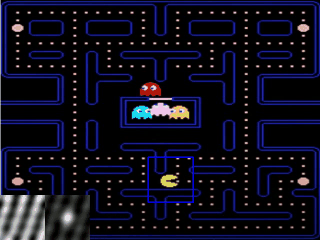

### First, let's combine function from file utils.py

In [2]:
# Extract the function in files utils.py
import numpy as np
import cv2

# used for linear mapping...
def linear_mapping(img):
    return (img - img.min()) / (img.max() - img.min())

# pre-processing the image...
def pre_process(img):
    # get the size of the img...
    height, width = img.shape
    img = np.log(img + 1)
    img = (img - np.mean(img)) / (np.std(img) + 1e-5)
    # use the hanning window...
    window = window_func_2d(height, width)
    img = img * window

    return img

def window_func_2d(height, width):
    win_col = np.hanning(width)
    win_row = np.hanning(height)
    mask_col, mask_row = np.meshgrid(win_col, win_row)

    win = mask_col * mask_row

    return win

def random_warp(img):
    a = -180 / 16
    b = 180 / 16
    r = a + (b - a) * np.random.uniform()
    # rotate the image...
    matrix_rot = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), r, 1)
    img_rot = cv2.warpAffine(np.uint8(img * 255), matrix_rot, (img.shape[1], img.shape[0]))
    img_rot = img_rot.astype(np.float32) / 255
    return img_rot


### Now, let's insert the mains function of the file mosse.py

- Select the region of interest (ROI) for tracking. The first frame video input will appearse.
- Modify the 'record' parameter to True to record an avi video.

Note: Different sizes of regions produce different results, as they take in more noise from the environment.


In [21]:
import numpy as np
import cv2
import os
#from utils import linear_mapping, pre_process, random_warp


class mosse:
    def __init__(self, video_path = 'pacman_celu.mp4', record = False):
        # get arguments..        
        self.lr = 0.125
        self.sigma = 100
        self.num_pretrain = 1
        self.rotate = False        
        self.video_path = video_path
        self.cap = cv2.VideoCapture(self.video_path)        
        self.record = record
    
    # start to do the object tracking...
    def start_tracking(self):
        # get the image of the first frame
        ret, init_img = self.cap.read()               
        if not ret:
            print("error")
            cv2.waitKey(0)
            return

        init_img = cv2.resize(init_img, (640,480), interpolation=cv2.INTER_AREA)        
        init_frame = cv2.cvtColor(init_img, cv2.COLOR_BGR2GRAY)                
        init_frame = init_frame.astype(np.float32)
        
        if self.record:            
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter('out_pacman.avi', fourcc, 20.0, (int(init_img.shape[1]),int(init_img.shape[0])))
        
        # get the init ground truth.. [x, y, width, height]
        init_gt = cv2.selectROI('demo', init_img, False, False)        
        init_gt = np.array(init_gt).astype(np.int64)
        print("finish selectROI")
        
        # start to draw the gaussian response...
        response_map = self._get_gauss_response(init_frame, init_gt)
        
        # start to create the training set ...
        # get the goal..
        g = response_map[init_gt[1]:init_gt[1]+init_gt[3], init_gt[0]:init_gt[0]+init_gt[2]]
        fi = init_frame[init_gt[1]:init_gt[1]+init_gt[3], init_gt[0]:init_gt[0]+init_gt[2]]
        G = np.fft.fft2(g)
        
        # start to do the pre-training...
        Ai, Bi = self._pre_training(fi, G)
        idx = -1
        # start the tracking...
        while True:    
            idx += 1
            ret, current_frame = self.cap.read()   
            if not ret:
                print("end/error")
                cv2.waitKey(0)
                break
            
            current_frame = cv2.resize(current_frame,(640,480), interpolation=cv2.INTER_AREA)
            frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)                        
            frame_gray = frame_gray.astype(np.float32)
            if idx == 0:
                Ai = self.lr * Ai
                Bi = self.lr * Bi
                pos = init_gt.copy()
                clip_pos = np.array([pos[0], pos[1], pos[0]+pos[2], pos[1]+pos[3]]).astype(np.int64)
            else:
                Hi = Ai / Bi
                fi = frame_gray[clip_pos[1]:clip_pos[3], clip_pos[0]:clip_pos[2]]
                fi = pre_process(cv2.resize(fi, (init_gt[2], init_gt[3])))
                Gi = Hi * np.fft.fft2(fi)                
                gi = linear_mapping(np.fft.ifft2(Gi))
                
                # muestro el filtro en dominio tiempo
                Filtro_hi = np.abs(255*linear_mapping(np.fft.ifft2(Hi))).astype(np.uint8)                
                #cv2.imshow('Filtro', Filtro_hi)                
                Result_gi = np.abs(255*gi).astype(np.uint8)
                #cv2.imshow('Gauss', np.abs(gi))
                
                # find the max pos...
                max_value = np.max(gi)
                max_pos = np.where(gi == max_value)
                dy = int(np.mean(max_pos[0]) - gi.shape[0] / 2)
                dx = int(np.mean(max_pos[1]) - gi.shape[1] / 2)
                
                # update the position...
                pos[0] = pos[0] + dx
                pos[1] = pos[1] + dy

                # trying to get the clipped position [xmin, ymin, xmax, ymax]
                clip_pos[0] = np.clip(pos[0], 0, current_frame.shape[1])
                clip_pos[1] = np.clip(pos[1], 0, current_frame.shape[0])
                clip_pos[2] = np.clip(pos[0]+pos[2], 0, current_frame.shape[1])
                clip_pos[3] = np.clip(pos[1]+pos[3], 0, current_frame.shape[0])
                clip_pos = clip_pos.astype(np.int64)

                # get the current fi..
                fi = frame_gray[clip_pos[1]:clip_pos[3], clip_pos[0]:clip_pos[2]]
                fi = pre_process(cv2.resize(fi, (init_gt[2], init_gt[3])))
                # online update...
                Ai = self.lr * (G * np.conjugate(np.fft.fft2(fi))) + (1 - self.lr) * Ai
                Bi = self.lr * (np.fft.fft2(fi) * np.conjugate(np.fft.fft2(fi))) + (1 - self.lr) * Bi
            
            # visualize the tracking process...
            cv2.rectangle(current_frame, (pos[0], pos[1]), (pos[0]+pos[2], pos[1]+pos[3]), (255, 0, 0), 2)
            if idx == 0:
                cv2.imshow('demo', current_frame)
            else:
                #merge the images of filter and gauss_response (hi,gi)            
                in_frame = current_frame.copy()
                hi_b = cv2.cvtColor(Filtro_hi, cv2.COLOR_GRAY2BGR)
                gi_b = cv2.cvtColor(Result_gi, cv2.COLOR_GRAY2BGR)
                rect_up = in_frame.shape[0] - hi_b.shape[0]
                rect_down = in_frame.shape[0]
                rect_right = hi_b.shape[1]
                rect_left = 0
                in_frame[rect_up:rect_down,rect_left:rect_right] = hi_b
                in_frame[rect_up:rect_down,rect_right:(rect_right * 2)] = gi_b
                cv2.imshow('demo', in_frame)
                if self.record:                    
                    out.write(in_frame)            
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break                

        self.cap.release()
        if self.record:
            out.release()
        return

    # pre train the filter on the first frame...
    def _pre_training(self, init_frame, G):
        height, width = G.shape
        fi = cv2.resize(init_frame, (width, height))
        # pre-process img..
        fi = pre_process(fi)
        Ai = G * np.conjugate(np.fft.fft2(fi))
        Bi = np.fft.fft2(init_frame) * np.conjugate(np.fft.fft2(init_frame))
        for _ in range(self.num_pretrain):
            if self.rotate:
                fi = pre_process(random_warp(init_frame))
            else:
                fi = pre_process(init_frame)
            Ai = Ai + G * np.conjugate(np.fft.fft2(fi))
            Bi = Bi + np.fft.fft2(fi) * np.conjugate(np.fft.fft2(fi))
        
        return Ai, Bi

    # get the ground-truth gaussian reponse...
    def _get_gauss_response(self, img, gt):
        # get the shape of the image..
        height, width = img.shape
        # get the mesh grid...
        xx, yy = np.meshgrid(np.arange(width), np.arange(height))
        # get the center of the object...
        center_x = gt[0] + 0.5 * gt[2]
        center_y = gt[1] + 0.5 * gt[3]
        # cal the distance...
        dist = (np.square(xx - center_x) + np.square(yy - center_y)) / (2 * self.sigma)
        # get the response map...
        response = np.exp(-dist)
        # normalize...
        response = linear_mapping(response)
        return response

    # it will extract the image list 
    def _get_img_lists(self, img_path):
        frame_list = []
        for frame in os.listdir(img_path):
            if os.path.splitext(frame)[1] == '.jpg':
                frame_list.append(os.path.join(img_path, frame)) 
        return frame_list
    
    # it will get the first ground truth of the video..
    def _get_init_ground_truth(self, img_path):
        gt_path = os.path.join(img_path, 'groundtruth.txt')
        with open(gt_path, 'r') as f:
            # just read the first frame...
            line = f.readline()
            gt_pos = line.split(',')

        return [float(element) for element in gt_pos]


In [23]:
img_path = 'pacman_sd.mp4'
tracker = mosse(img_path)
tracker.start_tracking()
cv2.destroyAllWindows()

finish selectROI
end/error
